In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os
import unicodedata
import re
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# hyperparameters
batch_size = 512
block_size = 100
max_iters = 5000
eval_interval = 300
eval_iters = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 384
n_heads = 8
n_layer = 6
dropout = 0.3

Mounted at /content/drive


In [ ]:
# load and preprocess data

folder_path = '/content/drive/MyDrive/nietzsche_texts'
nietzsche_works_train = ""
nietzsche_works_test = ""

for filename in os.listdir(folder_path):
    if filename.endswith(".txt") and filename != 'nietzsche_zarathustra_clean.txt':
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as file:
            tmp_file = file.read() + "\n"
            firstpart = int(len(tmp_file) * .8)
            train = tmp_file[:firstpart]
            test = tmp_file[firstpart:]
            nietzsche_works_train += train
            nietzsche_works_test += test

In [ ]:
def simplify_text(text):
    text = unicodedata.normalize("NFD", text)
    text = ''.join([char for char in text if not unicodedata.combining(char)])

    replacements = {
        '’': '"',
        '‘': '"',
        '“': '"',
        '”': '"',
        "'": '"',
        '—': '-',
        '–': '-',
        ';': ',',
        ':': ',',
        '§': '',
        'Æ': 'AE',
        'æ': 'ae',
        'Œ': 'OE',
        'œ': 'oe'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'[\n]', ' ', text)

    greek_to_latin = {
        'α': 'a', 'ά': 'a', 'β': 'b', 'γ': 'g', 'δ': 'd', 'ε': 'e',
        'έ': 'e', 'ζ': 'z', 'η': 'h', 'θ': 'th', 'ι': 'i', 'κ': 'k',
        'λ': 'l', 'μ': 'm', 'ν': 'n', 'ξ': 'x', 'ο': 'o', 'π': 'p',
        'ρ': 'r', 'ς': 's', 'σ': 's', 'τ': 't', 'υ': 'y', 'φ': 'f',
        'χ': 'ch', 'ω': 'o', 'ό': 'o'
    }
    for greek, latin in greek_to_latin.items():
        text = text.replace(greek, latin)

    allowed_chars = re.compile(r'[A-Za-z .,\'"!?-]')
    text = ''.join([char for char in text if allowed_chars.match(char)])

    return text

nietzsche_train_clean = simplify_text(nietzsche_works_train)
nietzsche_test_clean = simplify_text(nietzsche_works_test)


In [ ]:
# unique characters
chars = sorted(list(set(nietzsche_train_clean)))
vocab_size = len(chars)
print('Vocab size is:',  vocab_size, 'chars')

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


Vocab size is: 59 chars


In [ ]:

import re
matches = re.finditer(r"\.", nietzsche_train_clean[:500])
positions = [match.start() for match in matches]
print(positions)

nietzsche_train_clean[:500]


In [ ]:
# Train and test splits: first 90% will be train, rest val
data = torch.tensor(encode(nietzsche_train_clean), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

data_test = torch.tensor(encode(nietzsche_test_clean), dtype=torch.long)

In [ ]:
print("Dataset size:", len(data)+ len(data_test))
print("Train set size:", len(data))
print("Test set size:", len(data_test))

Dataset size: 1771198
Train set size: 1416760
Test set size: 354438


In [ ]:
# data loading: generate a small batch of data of inputs x and targets y, each with [batch_size * block_size] = (512,80)
def get_batch(split):
    data = train_data if split == 'train' else val_data # selected in estimate_loss function
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_heads) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape # B: batch_size, T=block_size (window length, time steps)

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # break if hit the next space ' '
            if idx_next == 0:
              break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

            idx_next = torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)

        return idx

    def generate_boring(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # directly choose the most probable character
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) # (B, 1)
            # append the chosen index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [ ]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# initialize variables to track the best loss and save path
best_val_loss = float('inf')  # Set to infinity initially
best_model_path = '/content/drive/MyDrive/autocomplete_models/auto_transformer_v03_best.pth'

for iter in range(max_iters):
    # [apparently this diversion slows down stuff incredibly: good to execute it only after every n iterations]
    # evaluate loss on train and val sets at intervals
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # check if the current validation loss is the best
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at step {iter} with val loss {best_val_loss:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


10.724411 M parameters
step 0: train loss 4.1905, val loss 4.1937
Best model saved at step 0 with val loss 4.1937
step 300: train loss 1.7951, val loss 1.7757
Best model saved at step 300 with val loss 1.7757
step 600: train loss 1.4413, val loss 1.4334
Best model saved at step 600 with val loss 1.4334
step 900: train loss 1.2948, val loss 1.2993
Best model saved at step 900 with val loss 1.2993
step 1200: train loss 1.2163, val loss 1.2311
Best model saved at step 1200 with val loss 1.2311
step 1500: train loss 1.1667, val loss 1.1938
Best model saved at step 1500 with val loss 1.1938
step 1800: train loss 1.1237, val loss 1.1642
Best model saved at step 1800 with val loss 1.1642
step 2100: train loss 1.0914, val loss 1.1478
Best model saved at step 2100 with val loss 1.1478
step 2400: train loss 1.0601, val loss 1.1295
Best model saved at step 2400 with val loss 1.1295
step 2700: train loss 1.0326, val loss 1.1136
Best model saved at step 2700 with val loss 1.1136
step 3000: train lo

In [ ]:
# save the model's state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/autocomplete_models/auto_transformer_v03.pth')

# save the optimizer's state dictionary (optional, useful for resuming training)
torch.save(optimizer.state_dict(), '/content/drive/MyDrive/autocomplete_models/auto_transformer_v03_optimizer_state.pth')


In [ ]:
# create model instance
model_loaded = GPTLanguageModel()
model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/autocomplete_models/auto_transformer_v03_best.pth'))
model_loaded = model_loaded.to(device)  # Move to device if necessary

optimizer = torch.optim.AdamW(model_loaded.parameters(), lr=learning_rate)


<ipython-input-15-cdac177a72fe>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/autocomplete_models/auto_tra

random val batch loss 1.0787, random test batch loss 1.2339


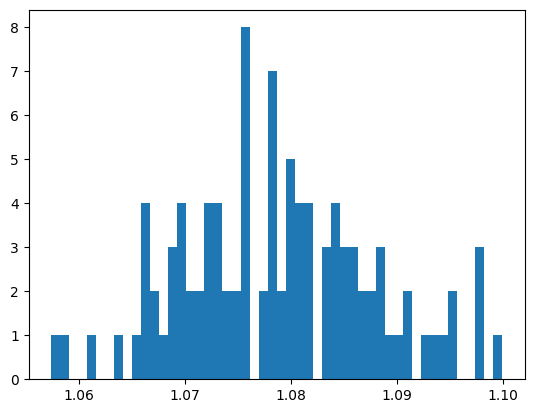

In [ ]:
# compute loss of loaded model on random val/test batch

def get_test_batch(split):
    # generate a small batch of data of inputs x and targets y, each with [batch_size * block_size] = (512,80)
    data = data_test if split == 'test' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

loss_rand = {}
model_loaded.eval()
for split in ['test', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_test_batch(split)
        logits, loss = model_loaded(X, Y)
        losses[k] = loss.item()
    loss_rand[split] = losses.mean()

print(f"random val batch loss {loss_rand['val']:.4f}, random test batch loss {loss_rand['test']:.4f}")

# distri val losses
from matplotlib import pyplot
pyplot.hist(losses.cpu().numpy(), bins=50)
pyplot.show()



In [ ]:
# generate from the model
seed_text = "The will to "  # Example starting text
seed_idx = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
generated = model_loaded.generate(seed_idx, max_new_tokens=100)
print(decode(generated[0].tolist()))

seed_text = "The will to p"
seed_idx = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
generated = model_loaded.generate(seed_idx, max_new_tokens=100)
print(decode(generated[0].tolist()))

seed_text = "The will to po"
seed_idx = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
generated = model_loaded.generate(seed_idx, max_new_tokens=100)
print(decode(generated[0].tolist()))


The will to dreamed
The will to period
The will to power,


In [ ]:
# test set autocompletion validation loop - strategy:
# 1) split test set into chunks ending in " ", " [a-z]" --> predict next word
# 2) loop to stack predictions and update input
# 3) repeat until predict " " (end of word)

sequence_length = block_size # =80

# repackage string into tensor of non-overlapping sequences w 80 chars each
idxs_seqs = np.arange(0,len(data_test), sequence_length)
data_test_tensor = data_test[:idxs_seqs[-1]].reshape(len(idxs_seqs)-1, sequence_length)

break_values = set(encode(chars[:8])) # break if model predicts non-character tokens, including " "

target_words = []
pred_words_1 = []
pred_words_2 = []
pred_acc_1 = [] # accuracy prediction based on context
pred_acc_2 = [] # accuracy prediction based on context + first character

# loop through sequences in tensor
for seq_i in range(data_test_tensor.shape[0]-1):
  # get indices of " " in sequence
  whitespace_locs = [i for i, e in enumerate(data_test_tensor[seq_i]) if e == 0]
  # cut out last complete word in sequence
  last_word_start = whitespace_locs[len(whitespace_locs)-2]
  last_word_stop = whitespace_locs[len(whitespace_locs)-1]
  word_targ_idx = data_test_tensor[seq_i][last_word_start+1:last_word_stop]
  target_word = decode(np.array(word_targ_idx))
  target_words.append(target_word)

  # cut and pad sequence
  gap_to_full_seq = sequence_length - len(data_test_tensor[seq_i][:last_word_start+1])
  padding = [0] * gap_to_full_seq
  padded_seq1 = padding + list(np.array(data_test_tensor[seq_i][:last_word_start+1])) # sequence before word
  padded_seq2 = padding[:len(padding)-1] + list(np.array(data_test_tensor[seq_i][:last_word_start+2])) # sequence before word plus 1st character of word


  # predict word from context
  word_pred_idx_1 = []
  seq_2_be_predicted = torch.tensor(padded_seq1).reshape(1, sequence_length)  # Reshape to (1, 80) for batch compatibility
  seq_2_be_predicted = seq_2_be_predicted.to(device)
  logits, loss = model_loaded(seq_2_be_predicted) # logits shape (1,80,60); loss is "None"
  # logits for last char in sequence
  logits = logits[0, -1, :] # shape (60)
  # return the indices of the maximum values along an axis
  pred_index = torch.argmax(logits)
  # store predicted index
  word_pred_idx_1.append(pred_index.item())

  # slide window
  while pred_index.item() != 0:
    padded_seq1.append(pred_index)
    padded_seq1 = padded_seq1[1:]

    seq_2_be_predicted = torch.tensor(padded_seq1).reshape(1, sequence_length)
    seq_2_be_predicted = seq_2_be_predicted.to(device)
    logits, loss = model_loaded(seq_2_be_predicted)
    logits = logits[0, -1, :] # shape (60)
    pred_index = torch.argmax(logits)
    if pred_index.item() in break_values: # == 0
        break
    word_pred_idx_1.append(pred_index.item())

  # validate against targets
  # return true if there is a (partial) match: allow "incomplete" predictions a la sinful -> sinfulness
  val1 = word_pred_idx_1 == list(np.array(word_targ_idx))[:len(word_pred_idx_1)]
  pred_acc_1.append(val1)


  # predict word from context + first character
  word_pred_idx_2 = [padded_seq2[len(padded_seq2)-1]] # first character of target work as baseline
  seq_2_be_predicted = torch.tensor(padded_seq2).reshape(1, sequence_length)  # Reshape to (1, 80) for batch compatibility
  seq_2_be_predicted = seq_2_be_predicted.to(device)
  logits, loss = model_loaded(seq_2_be_predicted) # logits shape (1,80,60); loss is "None"
  # logits for last char in sequence
  logits = logits[0, -1, :] # shape (60)
  # return the indices of the maximum values along an axis
  pred_index = torch.argmax(logits)
  # store predicted index
  if pred_index.item() != 0: # make sure that prediction is not an empty space (" ")
    word_pred_idx_2.append(pred_index.item())

  # slide window
  while pred_index.item() != 0:
    padded_seq2.append(pred_index)
    padded_seq2 = padded_seq2[1:]

    seq_2_be_predicted = torch.tensor(padded_seq2).reshape(1, sequence_length)
    seq_2_be_predicted = seq_2_be_predicted.to(device)
    logits, loss = model_loaded(seq_2_be_predicted)
    logits = logits[0, -1, :] # shape (60)
    pred_index = torch.argmax(logits)
    if pred_index.item() in break_values: #== 0:
        break
    word_pred_idx_2.append(pred_index.item())

  # validate against targets
  # return true if there is a (partial) match: allow incomplete predictions a la sinful -> sinfulness
  val2 = word_pred_idx_2 == list(np.array(word_targ_idx))[:len(word_pred_idx_2)]

  pred_acc_2.append(val2)

  pred_words_1.append(word_pred_idx_1)
  pred_words_2.append(word_pred_idx_2)


In [ ]:
print(np.unique(pred_acc_1, return_counts=True), np.unique(pred_acc_1, return_counts=True)[1]/len(pred_acc_1))
print(np.unique(pred_acc_2, return_counts=True), np.unique(pred_acc_2, return_counts=True)[1]/len(pred_acc_2))

(array([False,  True]), array([2808,  735])) [0.79254869 0.20745131]
(array([False,  True]), array([1947, 1596])) [0.54953429 0.45046571]


In [ ]:
# last instance
print("sequence: '", decode(data_test_tensor[seq_i].numpy()), "'" )
print('target word:', decode(np.array(word_targ_idx)))
print('predicted word:', decode(word_pred_idx_1 ))
print('predicted word:', decode(word_pred_idx_2 ))

sequence: ' ese most strange of all pursuits Zarathustra comes back with love to the narrowest and smallest thin '
target word: smallest
predicted word: most
predicted word: superficial


In [ ]:
print('targets:', target_words)
print('preds 1:', [decode(word) for word in pred_words_1])
print('eval 1:', pred_acc_1)
print('preds 2 :', [decode(word) for word in pred_words_2])
print('eval 2:', pred_acc_2)

targets: ['of', 'To', 'about', 'infallibly--these', 'antagonists', 'or', 'his', 'a', 'the', 'intellectual', 'prefers', 'of', 'whether', '.', 'and', 'the', 'it', 'time,', 'all', 'son.--I', 'be', 'is', 'offence.--Now,', 'requisite', 'example,', 'Germanic', 'conviction', 'historians,', 'survival', 'conviction,', 'have', 'gentlemen!', 'priests,', 'the', 'because', 'concepts,', 'categorical', 'truth', 'problems', 'genuine', 'could', 'the', 'the', 'be', 'the', 'to', 'the', 'to', '"holy', 'the', 'the', 'of', 'Christian', 'the', 'statement,', 'Kant"s', 'to', 'my', 'denial', 'of', 'an', 'intelligence', 'genuine', 'superstition,--it', 'what', 'nobles,', 'noble', 'and', 'fathomless', 'reverence', 'book', 'wife,', 'possible', 'the', 'kindly', 'being', 'in', 'always', 'cow,', 'a', 'Only', 'of', 'beside', 'strong', 'contemptible.--A', 'epitomizes', 'a', 'of', 'are', 'recites', 'the', 'a', 'is', 'how', 'complete', 'thing', 'in', 'wall', 'the', 'after', 'a', 'that', 'one"s', 'God', 'distract', 'those'

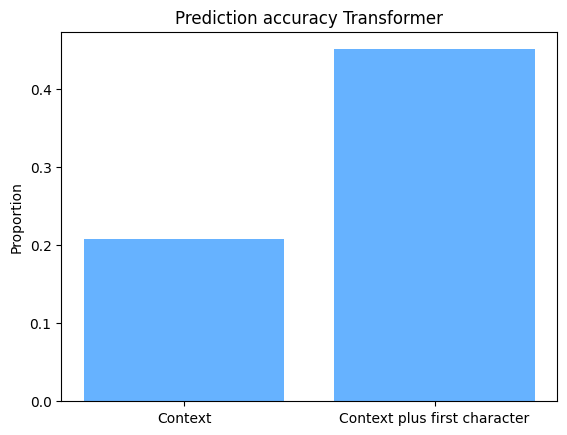

In [ ]:

from matplotlib import pyplot

proportions1 = np.unique(pred_acc_1, return_counts=True)[1] / len(pred_acc_1)
proportions2 = np.unique(pred_acc_2, return_counts=True)[1] / len(pred_acc_2)

data = np.array([proportions1, proportions2]).T  # Transpose for stacking

colors = ['#66B2FF']

fig, ax = pyplot.subplots()
pyplot.bar(['Context', 'Context plus first character'], data[1], label='True', color=colors[0]) # #bottom=data[0],

ax.set_ylabel('Proportion')
ax.set_title('Prediction accuracy Transformer')

pyplot.show()

In [ ]:
print(model_loaded.training) # check mode: FALSE if model.eval()
model_loaded.eval()
print(model_loaded.training)

False

In [ ]:
# prediction acc of 1, 2, 3, 5, 10 chars into the future
from matplotlib import pyplot

model_loaded.eval()
sequence_length = block_size + 0

# repackage string into tensor of non-overlapping sequences w 80 chars each
idxs_seqs = np.arange(0,len(data_test), sequence_length)
data_test_tensor = data_test[:idxs_seqs[-1]].reshape(len(idxs_seqs)-1, sequence_length)

comparison_vectors = []
comparison_vectors_next10 = []

# loop through sequences in tensor
for seq_i in range(data_test_tensor.shape[0]-1):
  input_idx = data_test_tensor[seq_i][:90-1] # first 90 chars of input seq
  word_targ_idx = data_test_tensor[seq_i][90-1:-1] # last 10 chars of input sequence (target)

  seq_2_be_predicted = input_idx.unsqueeze(0).to(device=device)  # Reshape to (1, 80) for batch compatibility
  word_targ_idx = word_targ_idx.to(device=device)

  preds = model_loaded.generate_boring(seq_2_be_predicted, max_new_tokens=10)

  next_10_preds = preds[0][-10:]

  comparison_vector = (word_targ_idx == next_10_preds).cpu().numpy() * 1
  comparison_vectors_next10.append(comparison_vector)


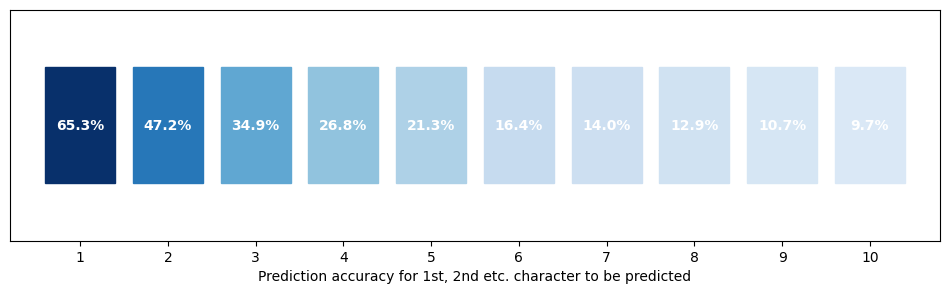

In [ ]:
import pandas as pd
tmp = pd.DataFrame(comparison_vectors_next10)
percs = tmp.sum(axis = 0) / tmp.shape[0]
percs_plot = np.array(percs)
np.round(percs_plot * 100, 0)

colors = pyplot.cm.Blues(percs_plot / max(percs_plot))


# define rectangle positions and heights based on probabilities
rect_width = 2
rect_height = 1
x_positions = np.arange(0, 10) * (rect_width + 0.5)

fig, ax = pyplot.subplots(figsize=(12, 3))

# draw rectangles and add percentages
for i, (x, prob) in enumerate(zip(x_positions, percs_plot)):
    color = colors[i]
    ax.add_patch(pyplot.Rectangle((x, 0), rect_width, rect_height, color=color))
    ax.text(
        x + rect_width / 2,
        rect_height / 2,
        f"{np.round(prob * 100, 1)}%",
        color="white",
        ha="center",
        va="center",
        fontsize=10,
        weight="bold"
    )

ax.set_xlim(-1, x_positions[-1] + rect_width + 1)
ax.set_ylim(-0.5, rect_height + 0.5)
ax.yaxis.set_visible(False)
ax.set_xticks(x_positions + rect_width/2)
ax.set_xticklabels(range(1,11))
ax.set_xlabel('Prediction accuracy for 1st, 2nd etc. character to be predicted')
pyplot.show()



In [ ]:
# top 3 words / pseudo "beam search"

sequence_length = block_size # =100

# repackage string into tensor of non-overlapping sequences w 80 chars each
idxs_seqs = np.arange(0,len(data_test), sequence_length)
data_test_tensor = data_test[:idxs_seqs[-1]].reshape(len(idxs_seqs)-1, sequence_length)

break_values = list(set(encode(chars[:8]))) # break if model predicts non-character tokens, including " "
break_values = torch.tensor(break_values).to(device)

model_loaded.eval()

pred_acc1 = [] # accuracy prediction based on context
pred_acc2 = [] # accuracy prediction based on context plus 1st character

# loop through sequences in tensor
for seq_i in range(data_test_tensor.shape[0]-1):
  # get indices of " " in sequence
  whitespace_locs = [i for i, e in enumerate(data_test_tensor[seq_i]) if e == 0]
  # cut out last complete word in sequence
  last_word_start = whitespace_locs[len(whitespace_locs)-2]
  last_word_stop = whitespace_locs[len(whitespace_locs)-1]
  word_targ_idx = data_test_tensor[seq_i][last_word_start+1:last_word_stop]

  # cut and pad sequence
  gap_to_full_seq = sequence_length - len(data_test_tensor[seq_i][:last_word_start+1])
  padding = [0] * gap_to_full_seq
  padded_seq = padding + list(np.array(data_test_tensor[seq_i][:last_word_start+1])) # sequence before word
  padded_seq = torch.tensor(padded_seq).reshape(1, sequence_length)  # Reshape to (1, 80) for batch compatibility
  padded_seq = padded_seq.to(device)
  padded_seq2 = padding[:len(padding)-1] + list(np.array(data_test_tensor[seq_i][:last_word_start+2])) # sequence before word plus 1st character of word
  padded_seq2 = torch.tensor(padded_seq2).reshape(1, sequence_length)  # Reshape to (1, 80) for batch compatibility
  padded_seq2 = padded_seq2.to(device)

  # predict top 3 words from context
  logits, loss = model_loaded(padded_seq) # logits shape (1,80,60); loss is "None"
  # logits for last char in sequence (shape (60))
  logits = logits[0, -1, :]
  # tensor of top k most likely characters
  pred_index_tnsr = torch.topk(logits, k=3)
  pred_index_tnsr_stacked = pred_index_tnsr.indices.reshape(3,1) # to be overwritten
  preds_tnsr = pred_index_tnsr_stacked # to store word

  # batch = 3 for subsequent preds
  # broadcasts padded sequences
  padded_tnsr = padded_seq.repeat(3, 1)
  # add tensor of preds for char1, cut first element from each row: dim = (3,100)
  padded_tnsr_sliding = torch.cat([padded_tnsr, pred_index_tnsr_stacked], axis=1)[:,1:]

  # slide window
  while True:
    logits, loss = model_loaded(padded_tnsr_sliding)
    # logits have shape (3,100,59): last char in sequence
    logits = logits[:, -1, :] # (3,59)
    pred_index_tnsr_stacked = torch.argmax(logits, dim = 1).reshape(3,1)

    # override: terminate sequence where prior iteration produced non-character token
    pred_index_tnsr_stacked[torch.isin(preds_tnsr[:,-1], break_values)] = 0

    if torch.all(torch.isin(pred_index_tnsr_stacked, break_values)): # if 000, returns FALSE
      break

    padded_tnsr_sliding = torch.cat([padded_tnsr_sliding, pred_index_tnsr_stacked], axis=1)[:,1:]
    preds_tnsr = torch.cat([preds_tnsr, pred_index_tnsr_stacked], axis = 1)

  # validate against targets: return true if there is a (partial) match: allow "incomplete" predictions a la sinful -> sinfulness
  solution1 = preds_tnsr[0, preds_tnsr[0,:] != 0]
  solution2 = preds_tnsr[1, preds_tnsr[1,:] != 0]
  solution3 = preds_tnsr[2, preds_tnsr[2,:] != 0]

  min_length = min(len(solution1), len(word_targ_idx))
  val1 = all(solution1[:min_length].cpu() == word_targ_idx[:min_length]) * 1
  min_length = min(len(solution2), len(word_targ_idx))
  val2 = all(solution2[:min_length].cpu() == word_targ_idx[:min_length]) * 1
  min_length = min(len(solution3), len(word_targ_idx))
  val3 = all(solution3[:min_length].cpu() == word_targ_idx[:min_length]) * 1

  pred_acc1.append(np.max([val1, val2, val3]))



  # predict top 3 words from context plus first character
  logits, loss = model_loaded(padded_seq2) # logits shape (1,80,60); loss is "None"
  # logits for last char in sequence (shape (60))
  logits = logits[0, -1, :]
  # tensor of top k most likely characters
  pred_index_tnsr = torch.topk(logits, k=3)

  # batch = 3 for subsequent preds
  # broadcasts padded sequences
  padded_tnsr = padded_seq2.repeat(3, 1)

  pred_index_tnsr_stacked = pred_index_tnsr.indices.reshape(3,1) # to be overwritten
  preds_tnsr = torch.cat([padded_tnsr[:, -1].unsqueeze(1), pred_index_tnsr_stacked[:,0].unsqueeze(1)], axis = 1) # to store word

  # add tensor of preds for char1, cut first element from each row: dim = (3,100)
  padded_tnsr_sliding = torch.cat([padded_tnsr, pred_index_tnsr_stacked], axis=1)[:,1:]
  #print(padded_tnsr_sliding)

  # slide window
  while True:
    logits, loss = model_loaded(padded_tnsr_sliding)
    # logits have shape (3,100,59): last char in sequence
    logits = logits[:, -1, :] # (3,59)
    pred_index_tnsr_stacked = torch.argmax(logits, dim = 1).reshape(3,1)

    # override: terminate sequence where prior iteration produced non-character token
    pred_index_tnsr_stacked[torch.isin(preds_tnsr[:,-1], break_values)] = 0

    if torch.all(torch.isin(pred_index_tnsr_stacked, break_values)): # if 000, returns FALSE
      break

    padded_tnsr_sliding = torch.cat([padded_tnsr_sliding, pred_index_tnsr_stacked], axis=1)[:,1:]
    preds_tnsr = torch.cat([preds_tnsr, pred_index_tnsr_stacked], axis = 1)

  # validate against targets: return true if there is a (partial) match: allow "incomplete" predictions a la sinful -> sinfulness
  solution1 = preds_tnsr[0, preds_tnsr[0,:] != 0]
  solution2 = preds_tnsr[1, preds_tnsr[1,:] != 0]
  solution3 = preds_tnsr[2, preds_tnsr[2,:] != 0]

  min_length = min(len(solution1), len(word_targ_idx))
  val1 = all(solution1[:min_length].cpu() == word_targ_idx[:min_length]) * 1
  min_length = min(len(solution2), len(word_targ_idx))
  val2 = all(solution2[:min_length].cpu() == word_targ_idx[:min_length]) * 1
  min_length = min(len(solution3), len(word_targ_idx))
  val3 = all(solution3[:min_length].cpu() == word_targ_idx[:min_length]) * 1

  pred_acc2.append(np.max([val1, val2, val3]))





In [ ]:
print(np.unique(pred_acc1,return_counts=True))
print(np.unique(pred_acc2,return_counts=True))

(array([0, 1]), array([2239, 1304]))
(array([0, 1]), array([1288, 2255]))


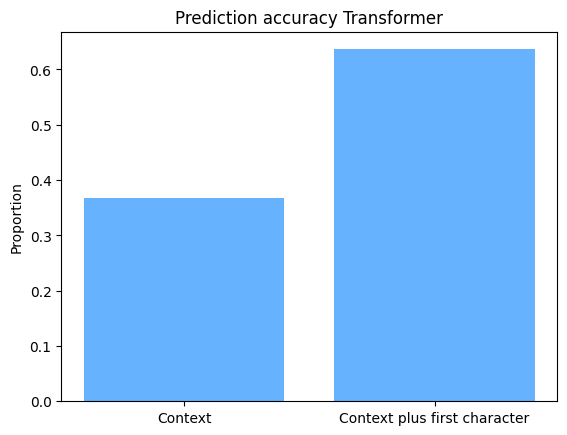

In [ ]:

from matplotlib import pyplot

proportions1 = np.unique(pred_acc1, return_counts=True)[1] / len(pred_acc1)
proportions2 = np.unique(pred_acc2, return_counts=True)[1] / len(pred_acc2)

data = np.array([proportions1, proportions2]).T  # Transpose for stacking

colors = ['#66B2FF']

fig, ax = pyplot.subplots()
pyplot.bar(['Context', 'Context plus first character'], data[1], label='True', color=colors[0]) # #bottom=data[0],

ax.set_ylabel('Proportion')
ax.set_title('Prediction accuracy Transformer')

pyplot.show()